# Feature selection in strength prediction with XGBoost

Copyright 2020 -
Leon Kellner, Merten Stender, Hamburg University of Technology, Germany

https://www2.tuhh.de/skf/

https://cgi.tu-harburg.de/~dynwww/cgi-bin/home/

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation,
either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

## 0.1 Packages

In [25]:
# clear jupyter lab workspace without user confirmation
%reset -f

# data handling modules
import pandas as pd
import numpy as np

# machine learning modules - pre- & postprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# machine learning modules - XGBoost
import xgboost as xgb

# explainable AI
import shap

# visualization
from matplotlib import pyplot as plt
import seaborn as sns

# other
import importlib
import pickle

# inhouse modules
import auxiliary_functions as aux  # repeatedly used functions are outsourced to this module
import data_preprocessing as dp    # data preprocessing module
importlib.reload(dp)  # automatic reload (sometimes needed)
importlib.reload(aux)

<module 'auxiliary_functions' from 'D:\\05_Feature_selection\\feature-selection-2020-paper\\auxiliary_functions.py'>

## 0.2 Variables and constants

In [26]:
# control variables - data cleaning
onehot_ = False        # one-hot encode data t/f
freshwater_ = False    # only use freshwater ice data t/f
drop_nan_ = False      # drop all rows that contain nan values after data cleaning t/f, not necessary for XGBoost trees
exp_cat_ = False       # Take exponential of ordinally encoded categorical data to increase distance between categories
drop_outlier_ = 0      # drop values > this value in strength values 
if freshwater_ == True : drop_outlier_ = 75.0 
transform_y = False    # transform target values for better prediction

# contral variables - code execution
use_kfold = True       # check for overfitting with kfold cross validation
exploratory = True     # do exploratory data analysis  t/f
random_state_ = 9      # random state for reproducible output

# global training constants and hyperparameters
# see also https://xgboost.readthedocs.io/en/latest/parameter.html
MAX_LEAVES = 8             # p. 363, T. Hastie et al., The elements of statistical learning: Data mining, inference, and prediction, 2009.
LEARNING_RATE = 0.07       # J. H. Friedman, “Stochastic gradient boosting,” Computational Statistics & Data Analysis, vol. 38, no. 4, pp. 367–378, 2002
SUBSAMPLE = 0.5            # Also Friedman paper
NUM_BOOST_ROUNDS = 500     # Number of gradient boosted trees. Equivalent to number of boosting rounds.
EARLY_STOPPING_ROUNDS = 5  # Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training
EVAL_METRICS = ['mae', 'rmse']   # last metric in this list will be used for early stopping during training
#OBJECTIVE = "reg:pseudohubererror"
#OBJECTIVE = "reg:squaredlogerror"  # root mean square log error
OBJECTIVE = "reg:squarederror"    #  regression with squared loss

# some general variables for postprocessing
dpi_ = 1000                     # resolution for figures
fig_size_ = aux.cm2inch(12, 8)  # figure size

# file name templates for saving files, figures and models
if freshwater_:
    fig_path_name_template = "raw_figures/rgsr_xgb_fw_"
    excel_path_name_template = 'excel_outputs/rgsr_xgb_fw_'
    model_path_name_template = 'models/rgsr_xgb_fw_'
else:
    fig_path_name_template = "raw_figures/rgsr_xgb_sw_"    
    excel_path_name_template = 'excel_outputs/rgsr_xgb_sw_'
    model_path_name_template = 'models/rgsr_xgb_sw_'

## 1. Import and prep data

In [27]:
file = 'data points_v1.12.xlsx'
data = dp.data_cleaning(filename=file)  # method agnostic initial data cleaning

# method specific data cleaning & split into encoded and non-encoded data
# Display datasets are not encoded or scaled, and will be used in visualization later
X, y, X_display, y_display = dp.data_prep_strength_pred(data, freshwater=freshwater_, onehot=onehot_, 
                                                        drop_nan=drop_nan_, drop_outlier=drop_outlier_, exp_cat=exp_cat_) 

# transform target values for better prediction (strength is almost log-normally distributed)
if transform_y: y = dp.transform_target(y, back=False) 
    
# if root mean square log error if used, y cannot contain negative values
if OBJECTIVE == "reg:squaredlogerror":  
    assert not any(y < 0)  # assert that not any value in y is negative

num_features = X.shape[1]
num_samples = data.shape[0]
X.to_excel(excel_path_name_template + 'X.xlsx',index=True, header=True)
X_display.to_excel(excel_path_name_template + 'X_display.xlsx',index=True, header=True)

# train, test, and validation splits
split = 0.2
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=split, shuffle=True, random_state=random_state_)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=split, shuffle=True, random_state=random_state_)

# tidy features names for later visualizations 
if freshwater_:
    name_map = {
        "strain_rate": "Strain rate",
        "triaxiality": "Triaxiality",
        "temperature": "Temperature",
        "volume": "Volume",
        "porosity": "Porosity",
        "grain_size": "Grain size", 
        "type_test": "Type of test",
        "columnar_loading": "Columnar loading",
        "type_ice": "Type of ice",
    }
else:
    name_map = {
        "temperature": "Temperature",
        "columnar_loading": "Columnar loading",
        "strain_rate": "Strain rate",
        "type_ice": "Type of ice",
        "porosity": "Porosity",
        "volume": "Volume",
        "type_test": "Type of test",
        "salinity": "Salinity", 
        "triaxiality": "Triaxiality",
    }
display_feature_names = list(map(lambda x: name_map.get(x, x), X.columns))

Encoded columnar loading:  along  =  2.0
Encoded type of ice:  columnar  =  0.0


In [28]:
# Switch categorical variables in display dataset to string variables
# This might be necessary for some visualizations later, but not mandatory
X_display = X_display.astype({'type_test': 'string', 'type_ice': 'string', 'columnar_loading': 'string'}, copy=True)

# Rename display data set columns with respective name maps
X_display.rename(columns = name_map, inplace=True)

# Display display dataset and dtypes if desired
#X_display.head()
#X_display.dtypes

## 1.1 Exploratory data analysis

(2203, 9) (2203,) (2203, 9) (2203,)
number of input feautures: 9
number of samples (overall): 3031


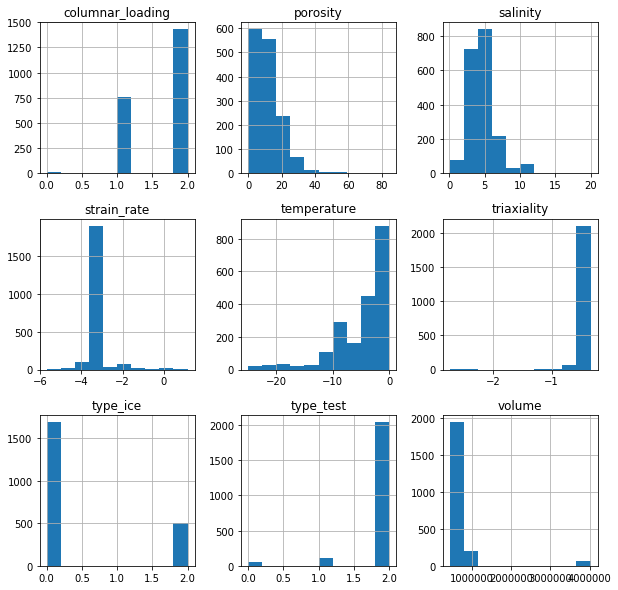

targets: number of behavior type 1: 8803.84059429588
targets: number of behavior type 0: -6600.84059429588
the imbalance is: [399.62962298]:[-299.62962298]
the expected value is:4.0


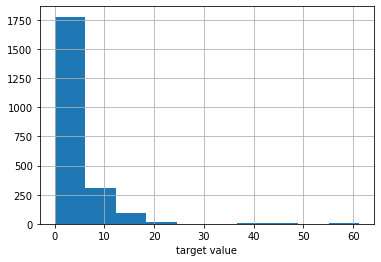

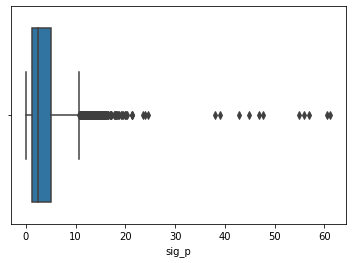

In [29]:
if exploratory:
    # check and output shapes and features
    print(X.shape, y.shape, X_display.shape, y_display.shape)   
    print(f'number of input feautures: {num_features}')
    print(f'number of samples (overall): {num_samples}')

    # a histogram of all inputs
    hist_inputs = X.hist(layout=(3,3), figsize=(10,10));
    plt.show()

    # a histogram of all outputs
    print('targets: number of behavior type 1: ' + str(np.sum(y)))
    print('targets: number of behavior type 0: ' + str(len(y)-np.sum(y)))
    print('the imbalance is: ' + str(np.sum(y)/y.shape*100) + ':' + str((len(y)-np.sum(y))/y.shape*100))
    print('the expected value is:' + str(np.round(np.mean(y),2)))
    hist_outputs = y.hist();
    plt.xlabel('target value')
    plt.show()
    if transform_y:
        hist_outputs = dp.transform_target(y, back=True).hist();
        plt.xlabel('target value non-transformed')
        plt.show()

    # boxplot of strength values to detect outliers
    sns.boxplot(x=y)
    plt.show()
    if transform_y:
        sns.boxplot(x=dp.transform_target(y, back=True))
        plt.show()

## 2. Data preparation & cross validation of a XGBoost model

In [30]:
# --- model building and training function
def build_train_model(Dtrain, Dtest):
    """Build and train XGBoost model.

    Parameters
    ----------
    Dtrain, Dtest : xgboost.DMatrix
        Train and test/evaluation data sets in native XGBoost format.


    Returns
    -------
    xgboost.Booster, dictionary

    """
    parameters_booster = {
        "max_leaves": MAX_LEAVES,         
        "grow_policy": 'lossguide',  # needs to be defined for max_leaves parameter
        "tree_method": 'hist',       # needs to be defined for max_leaves parameter
        "learning_rate": LEARNING_RATE,
        "subsample": SUBSAMPLE,     
        "objective": OBJECTIVE,
        "eval_metric": EVAL_METRICS,
    }
    progress = dict()  # training progress

    # compile and train model, return model and training progress
    model = xgb.train(parameters_booster, Dtrain, verbose_eval=False,
                      evals=[(Dtrain, 'train'), (Dtest, 'eval')],
                      early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                      evals_result=progress, num_boost_round=NUM_BOOST_ROUNDS)
    return model, progress

# --- model checking
# use cross validation to find out whether the model architecture is well suited for the problem
if use_kfold:
    metrics_cv = {'rmse': [], 'mae': [], 'rmsle': []}  # store crossvalidation results in a dict
    kfold = KFold(n_splits=5, shuffle=True)
    for train, test in kfold.split(X_train_val, y_train_val):
        
        # split fold test data into validation set for early stopping and test set for performance evaluation
        Xfold_eval, Xfold_test, yfold_eval, yfold_test = train_test_split(X_train_val.iloc[test, :], y_train_val.iloc[test], test_size=0.5, shuffle=True, random_state=random_state_)

        Dtrain = xgb.DMatrix(X_train_val.iloc[train, :], y_train_val.iloc[train])  # the current training data
        Deval = xgb.DMatrix(Xfold_eval, yfold_eval)     # current validation data for early stopping
        Dtest = xgb.DMatrix(Xfold_test, yfold_test)     # current test data for performance evaluation
        model, progress = build_train_model(Dtrain, Deval)
        yfold_predict = model.predict(Dtest)
        
        if transform_y:  
            # transform predicted and test target values back for better interpretation of results
            yfold_test = dp.transform_target(yfold_test, back=True)
            yfold_predict = dp.transform_target(yfold_predict, back=True)
        current_metrics = aux.regression_metrics(yfold_predict, yfold_test)
        metrics_cv['rmse'].append(current_metrics['rmse'])
        metrics_cv['mae'].append(current_metrics['mae'])
        metrics_cv['rmsle'].append(current_metrics['rmsle'])

    # add mean of kfold metric values
    metrics_cv['rmse_mean'] = np.mean(metrics_cv['rmse'])
    metrics_cv['mae_mean'] = np.mean(metrics_cv['mae'])
    metrics_cv['rmsle_mean'] = np.mean(metrics_cv['rmsle'])

    # report the CV results
    print('cross-validation performance RMSE :', np.round(metrics_cv['rmse'], 2), ', mean: ', str(np.round(metrics_cv['rmse_mean'], 2)), ', SD +/-: ', str(np.std(metrics_cv['rmse'])))
    print('cross-validation performance MAE :', np.round(metrics_cv['mae'], 2), ', mean: ', str(np.round(metrics_cv['mae_mean'], 2)), ', SD +/-: ', str(np.std(metrics_cv['mae'])))
    print('cross-validation performance RMSLE :', np.round(metrics_cv['rmsle'], 2), ', mean: ', str(np.round(metrics_cv['rmsle_mean'], 2)), ', SD +/-: ', str(np.std(metrics_cv['rmsle'])))

cross-validation performance RMSE : [2.09 2.65 2.03 2.33 2.37] , mean:  2.29 , SD +/-:  0.2237001087900716
cross-validation performance MAE : [1.24 1.5  1.26 1.49 1.51] , mean:  1.4 , SD +/-:  0.12204123274149103
cross-validation performance RMSLE : [0.38 0.44 0.36 0.38 0.39] , mean:  0.39 , SD +/-:  0.02455063719871303


## 3. Train the final classifier

In [31]:
Dtrain = xgb.DMatrix(X_train, y_train)  # convert training data to XGBoost native data format
Deval = xgb.DMatrix(X_val, y_val)
Dtest = xgb.DMatrix(X_test, y_test)

# build and save final model, save training progress, and get predictions
model, progress_final = build_train_model(Dtrain, Deval)  
pickle.dump(model, open(model_path_name_template + "pickle.dat", "wb"))
y_predict = model.predict(Dtest)

# transform predicted and test target values back for better interpretation of results
if transform_y:  
    y_test = dp.transform_target(y_test, back=True)
    y_predict = dp.transform_target(y_predict, back=True)
    
# save to excel tables if desired
pd.DataFrame(y_predict).to_excel(excel_path_name_template + 'y_predict.xlsx',index=False, header=False)  
y_test.to_excel(excel_path_name_template + 'y_test.xlsx',index=False, header=False)

metrics_final = aux.regression_metrics(y_predict, y_test)

# report the results of the final classifier on the test data set
print('test set score of the final classifier - RMSE: ', str(np.round(metrics_final['rmse'], 2)))
print('test set score of the final classifier - MAE: ', str(np.round(metrics_final['mae'], 2)))
print('test set score of the final classifier - RMSLE: ', str(np.round(metrics_final['rmsle'], 2)))

test set score of the final classifier - RMSE:  2.1
test set score of the final classifier - MAE:  1.31
test set score of the final classifier - RMSLE:  0.34


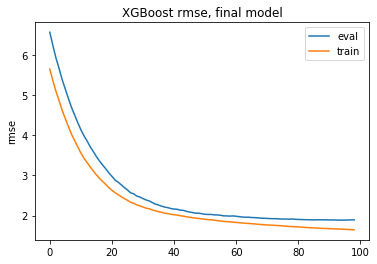

In [32]:
# plot the training history of the final classifier
plot_metric = aux.is_list(EVAL_METRICS, -1)  # If eval_metric is list, get last entry (used for early stopping)
x_axis = range(0, len(progress_final['eval'][plot_metric]))
fig, ax = plt.subplots()
ax.plot(x_axis, progress_final['eval'][plot_metric], label='eval')
ax.plot(x_axis, progress_final['train'][plot_metric], label='train')
ax.legend()
plt.ylabel(plot_metric)
plt.title('XGBoost ' + plot_metric + ', final model')
plt.show()

# use the following hack for shap 1.1 until this issue is fixed: https://github.com/slundberg/shap/issues/1215
# https://github.com/slundberg/shap/issues/1215#issuecomment-641102855
model_bytearray = model.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
model.save_raw = myfun

## 4. Postprocessing of results
## 4.1 Explain predictions for all observations

Build explainer for the complete data.

In [33]:
shap.initjs()  # necessary for shap visualization

explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(X)  # Estimate the SHAP values for all data (this is fast for boosted trees)

# save test shap values to excel
df_shap_values = pd.DataFrame(shap_values)
df_shap_values.to_excel(excel_path_name_template + 'shap_values.xlsx',index=True, header=True)  

# check shape if desired - should be the same as data matrix
print('Shape of shap values: ', shap_values.shape)  
print('Shape of data matrix: ', X.shape)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Shape of shap values:  (2203, 9)
Shape of data matrix:  (2203, 9)


### Importance of features
Typical SHAP importance ranking for the complete data set. 

<function matplotlib.pyplot.show(*args, **kw)>

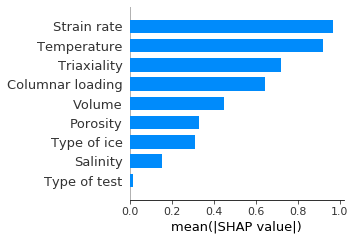

In [34]:
max_display_ = 9
f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values, X, feature_names=display_feature_names, plot_type="bar", plot_size=None, show=False, max_display=max_display_)
plt.xlabel("mean(|SHAP value|)")
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "ranking_bar.pdf", format='pdf',  dpi=dpi_)  
plt.show

### SHAP summary plot

Density scatter plot of SHAP values for each feature.

<function matplotlib.pyplot.show(*args, **kw)>

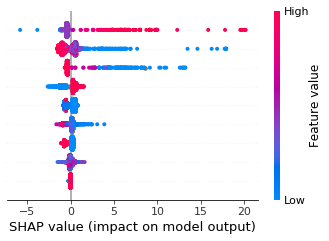

In [35]:
f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values, X, feature_names=["" for m in display_feature_names], show=False, plot_size=None, max_display=max_display_)
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "summary.pdf", dpi=dpi_, format='pdf')
plt.show

## 4.2 Specific interaction effects
Use dependence plots to further investigate some of the top features and their interactions, based on the behavior in the summary plots.

invalid value encountered in less


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 340.157x226.772 with 0 Axes>

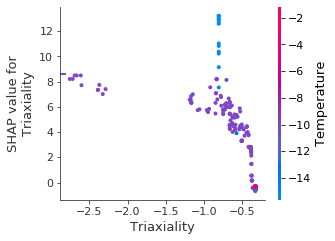

In [36]:
f = plt.figure(figsize=fig_size_)
interaction_index_ = 'Temperature'
main_index = 'Triaxiality'
f = shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names), 
                         interaction_index=interaction_index_, show=False)
plt.gcf().set_size_inches(fig_size_)  
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 340.157x226.772 with 0 Axes>

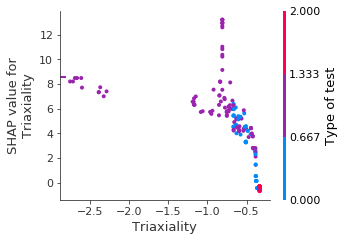

In [37]:
f = plt.figure(figsize=fig_size_)
interaction_index_ = 'Type of test'
main_index = 'Triaxiality'
f = shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names), 
                         interaction_index=interaction_index_, show=False)
#cbar = plt.gca().collections[0].colorbar
#cbar.set_ticklabels(['biaxial', 'triaxial', 'uniaxial'])
#cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation='vertical')
#cbar.set_ticks([0.5, 1.2, 1.8])
plt.gcf().set_size_inches(fig_size_)  
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 340.157x226.772 with 0 Axes>

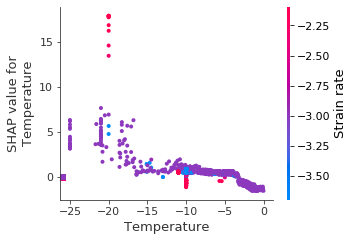

In [38]:
f = plt.figure(figsize=fig_size_)
interaction_index_ = 'Strain rate'
main_index = 'Temperature'
f = shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names),
                         interaction_index=interaction_index_, show=False, x_jitter=2)
plt.gcf().set_size_inches(fig_size_) 
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
plt.show

invalid value encountered in less


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 340.157x226.772 with 0 Axes>

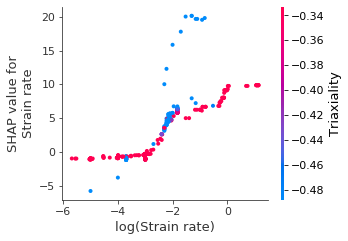

In [39]:
f = plt.figure(figsize=fig_size_)
interaction_index_ = 'Triaxiality'
main_index = 'Strain rate'
f = shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names),
                         interaction_index=interaction_index_, show=False)
plt.gcf().set_size_inches(fig_size_)  
plt.xlabel("log(Strain rate)")
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 340.157x226.772 with 0 Axes>

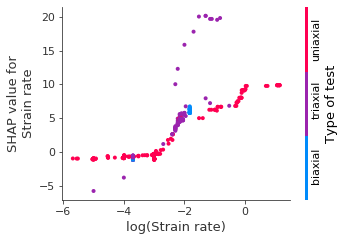

In [40]:
f = plt.figure(figsize=fig_size_)
interaction_index_ = 'Type of test'
main_index = 'Strain rate'
f = shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names),
                         interaction_index=interaction_index_, show=False, x_jitter=2)
cbar = plt.gca().collections[0].colorbar
cbar.set_ticklabels(['biaxial', 'triaxial', 'uniaxial'])
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation='vertical')
cbar.set_ticks([0.5, 1.2, 1.85])
plt.gcf().set_size_inches(fig_size_)  
plt.xlabel("log(Strain rate)")
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
plt.show

invalid value encountered in less


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 340.157x226.772 with 0 Axes>

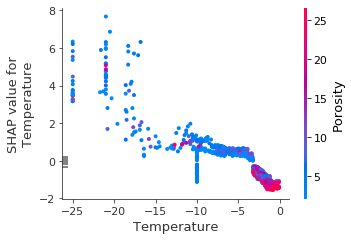

In [41]:
f = plt.figure(figsize=fig_size_)
interaction_index_ = 'Porosity'
main_index = 'Temperature'
f = shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names),
                         interaction_index=interaction_index_, show=False, x_jitter=2)
plt.gcf().set_size_inches(fig_size_)  
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
plt.show

invalid value encountered in less


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 340.157x226.772 with 0 Axes>

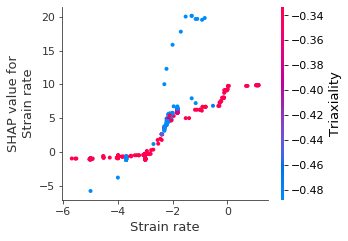

In [42]:
f = plt.figure(figsize=fig_size_)
interaction_index_ = 'Triaxiality'
main_index = 'Strain rate'
f = shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names),
                         interaction_index=interaction_index_, show=False)
plt.gcf().set_size_inches(fig_size_)  
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
plt.show

invalid value encountered in less


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 340.157x226.772 with 0 Axes>

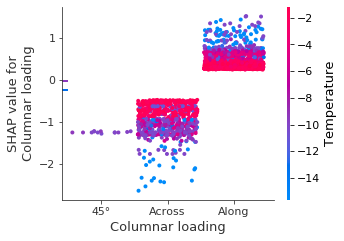

In [43]:
f = plt.figure(figsize=fig_size_)
interaction_index_ = 'Temperature'
main_index = 'Columnar loading'
f = shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names),
                         interaction_index=interaction_index_, show=False, x_jitter=0.9)
plt.xticks([0, 1, 2], ('45°', 'Across', ('Along')))
plt.gcf().set_size_inches(fig_size_)  
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
plt.show

invalid value encountered in greater_equal
invalid value encountered in less
invalid value encountered in greater_equal


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 340.157x226.772 with 0 Axes>

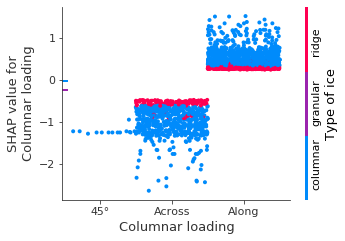

In [44]:
f = plt.figure(figsize=fig_size_)
interaction_index_ = 'Type of ice'
main_index = 'Columnar loading'
f = shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names),
                         interaction_index=interaction_index_, show=False, x_jitter=3)
cbar = plt.gca().collections[0].colorbar
cbar.set_ticklabels(['columnar', 'granular', 'ridge'])
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation='vertical')
cbar.set_ticks([0.6, 1.21, 1.75])
plt.xticks([0, 1, 2], ('45°', 'Across', 'Along'))
plt.gcf().set_size_inches(fig_size_)  
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
plt.show

invalid value encountered in less


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 340.157x226.772 with 0 Axes>

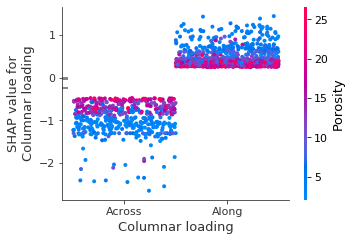

In [45]:
f = plt.figure(figsize=fig_size_)
interaction_index_ = 'Porosity'
main_index = 'Columnar loading'
f = shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names),
                         interaction_index=interaction_index_, show=False, x_jitter=3)
plt.xticks([1, 2], ('Across', 'Along'))
plt.gcf().set_size_inches(fig_size_)  
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
plt.show

## 4.3 All interaction effects
To check for possible interactions, plot all possible dependence plots.

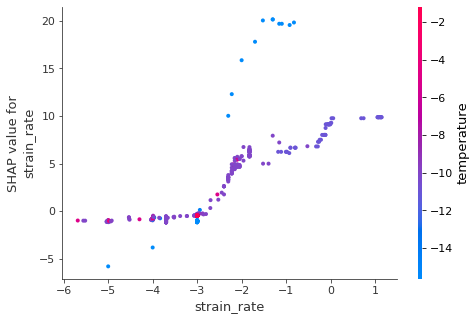

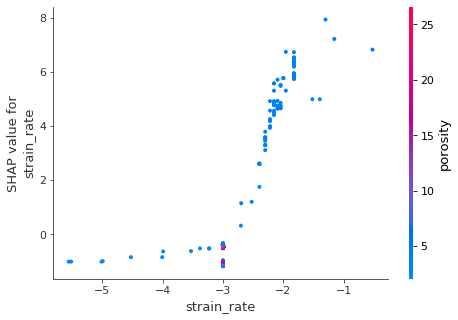

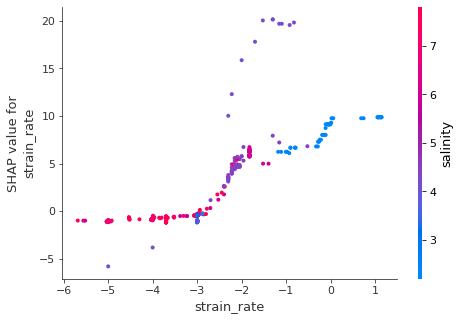

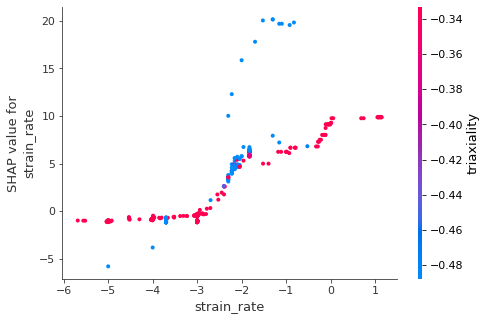

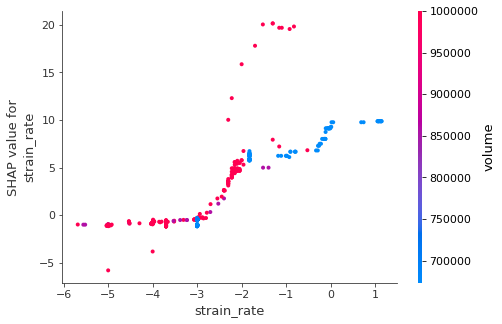

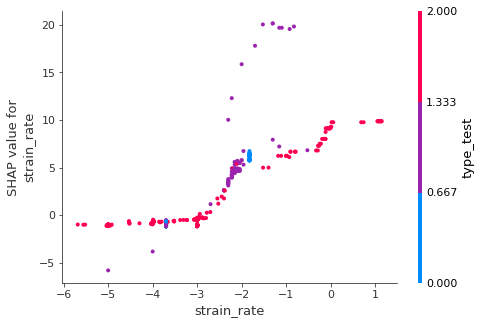

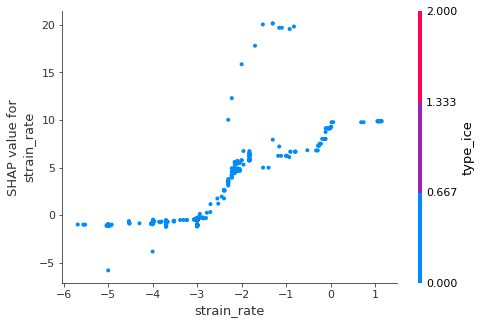

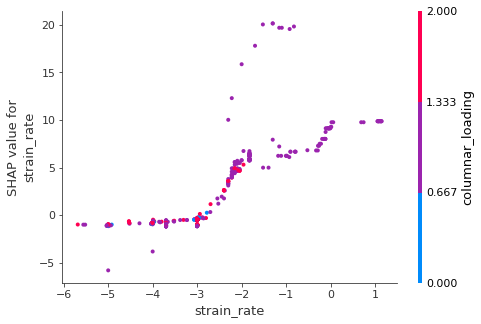

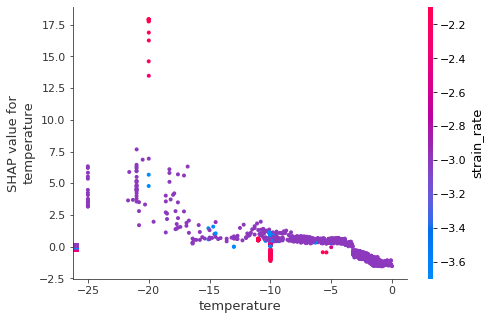

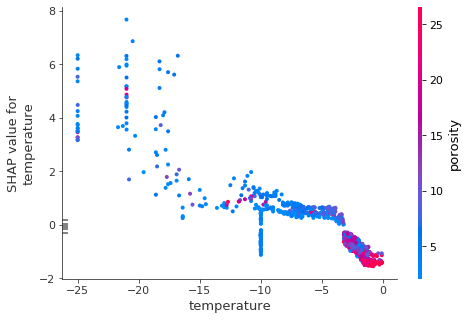

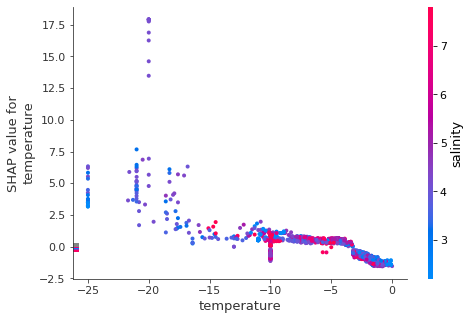

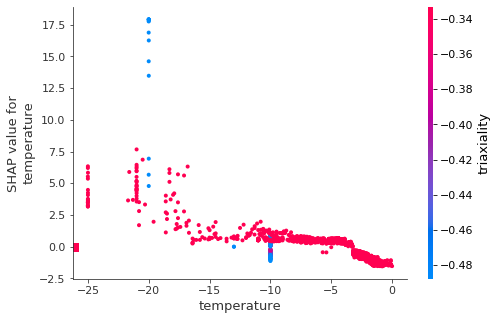

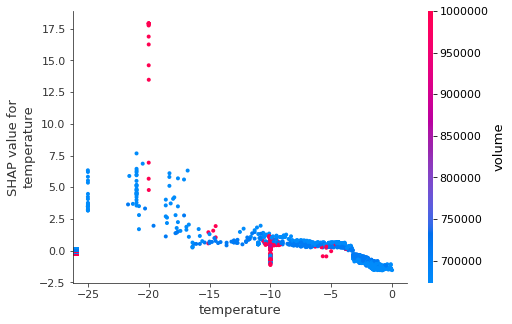

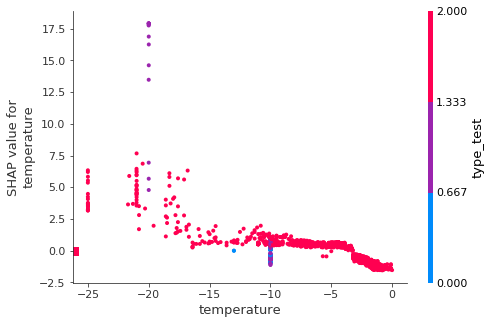

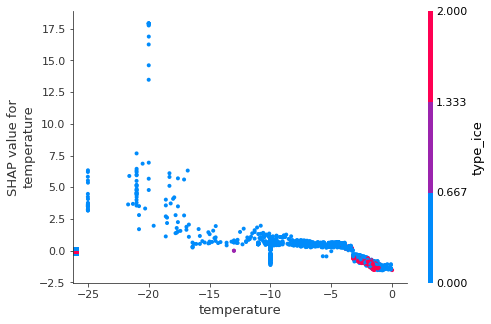

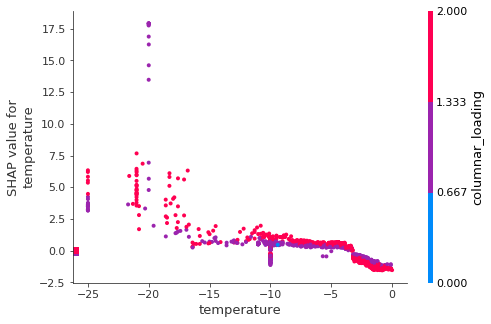

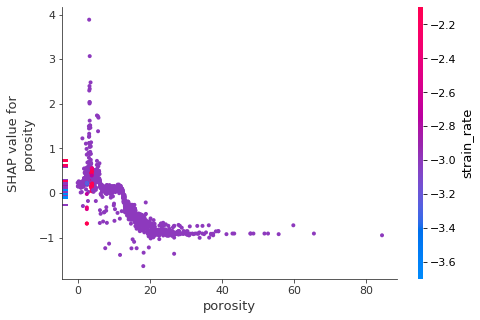

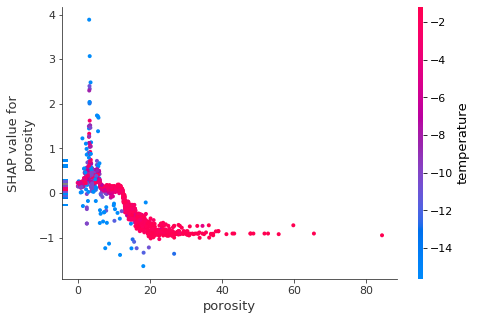

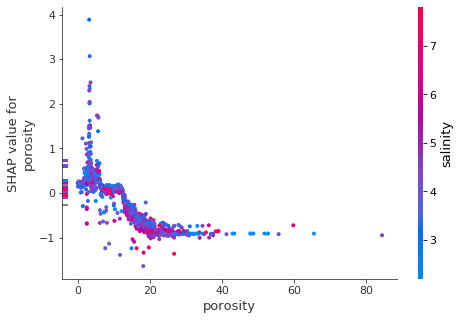

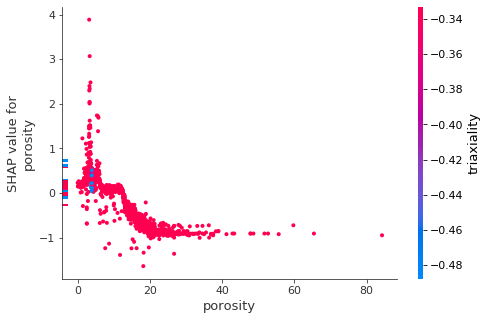

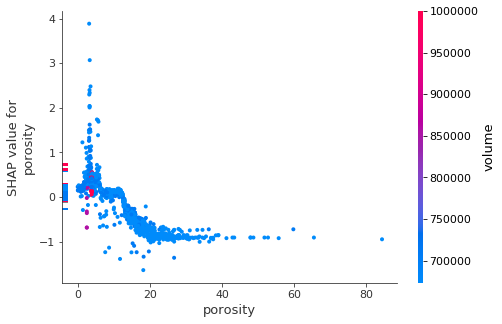

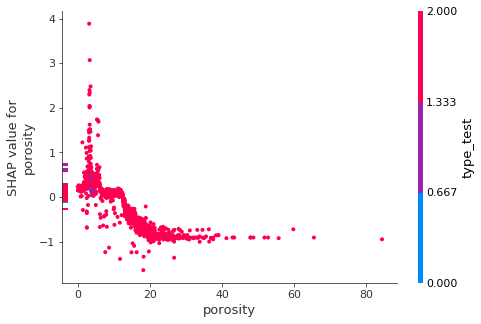

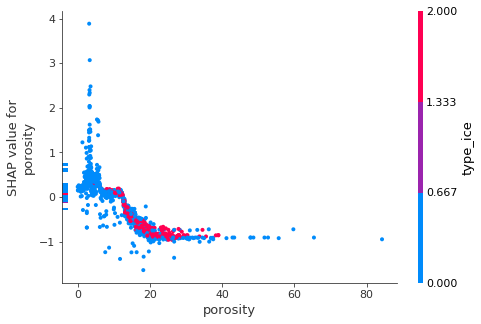

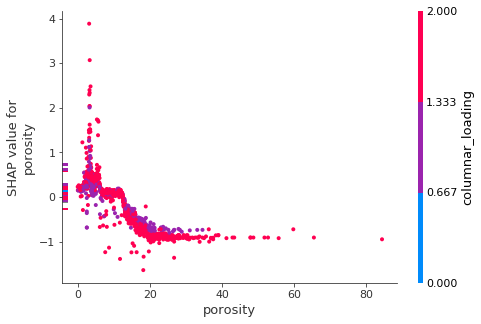

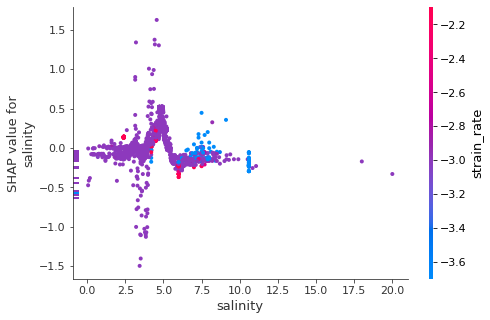

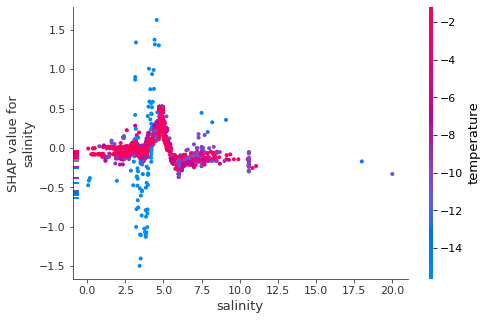

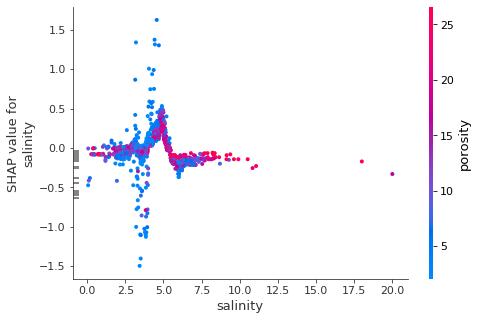

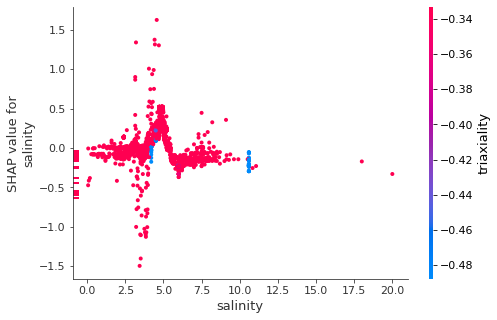

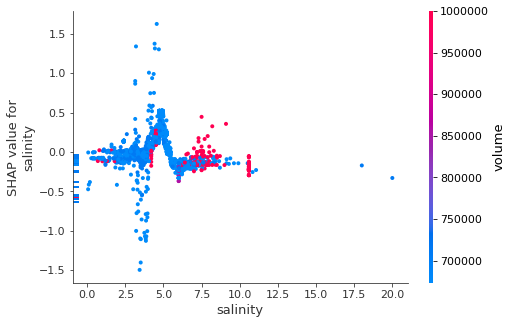

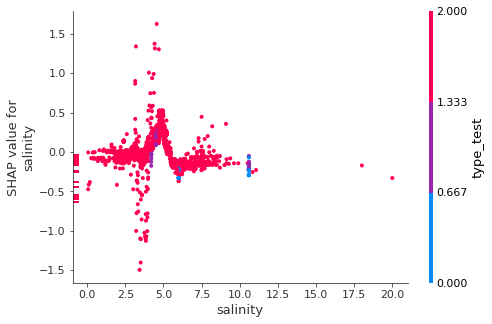

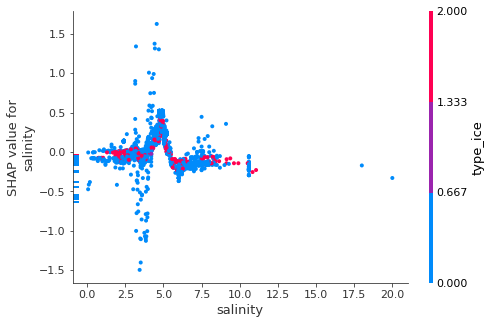

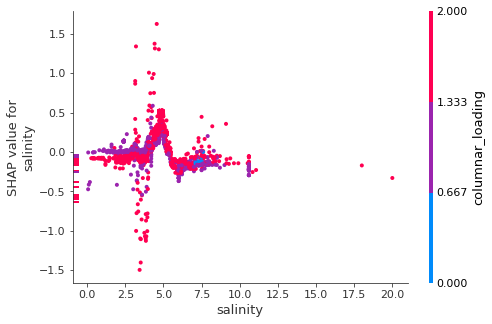

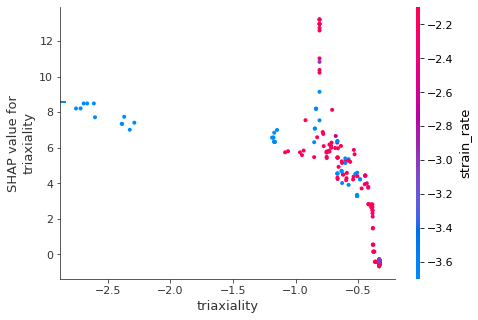

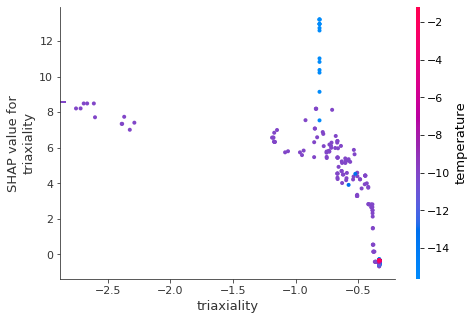

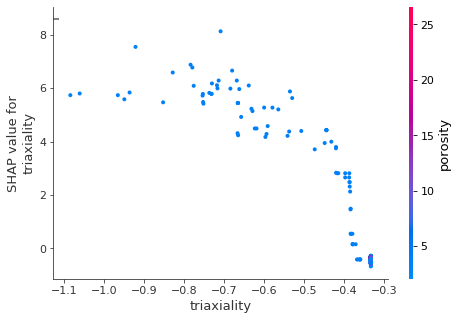

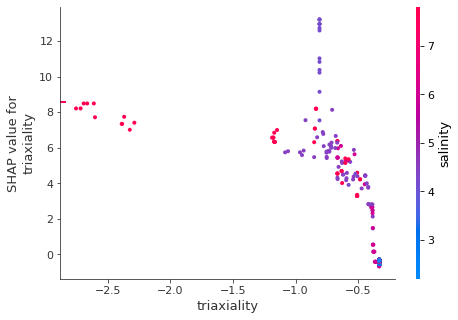

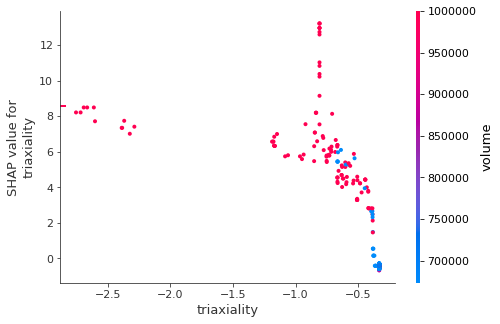

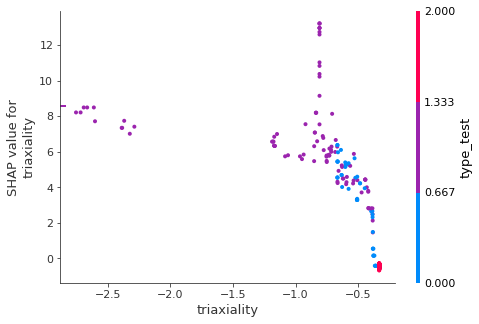

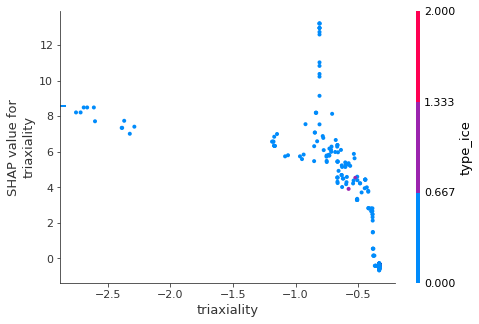

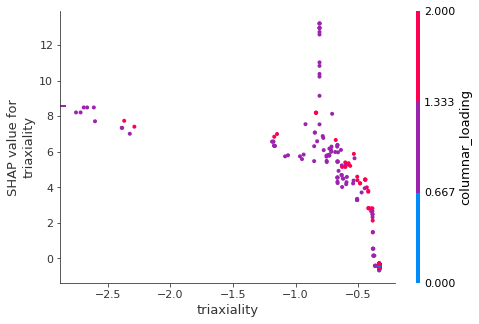

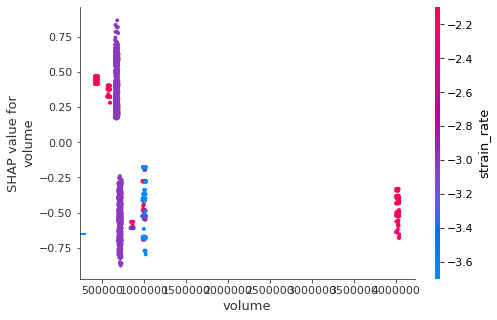

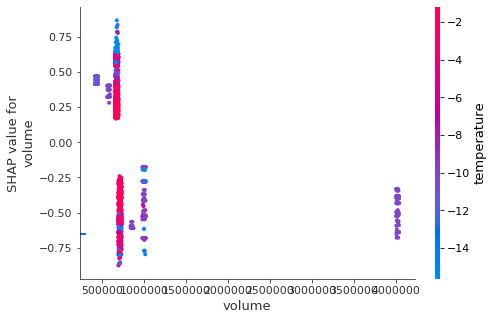

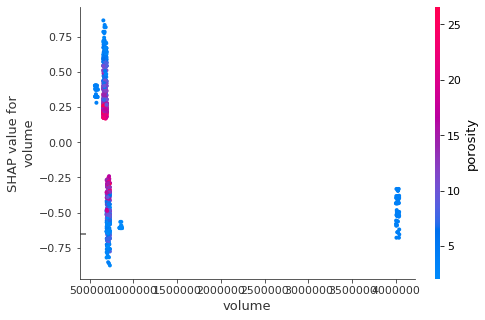

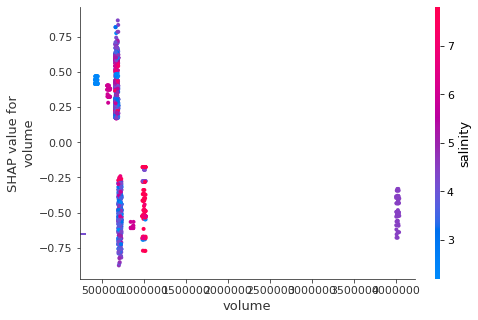

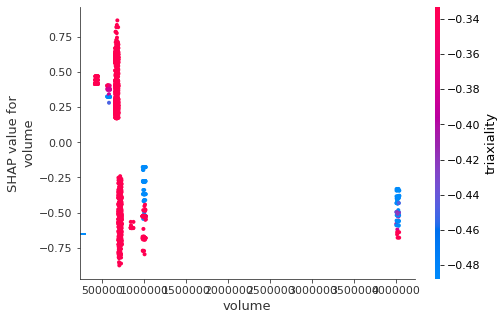

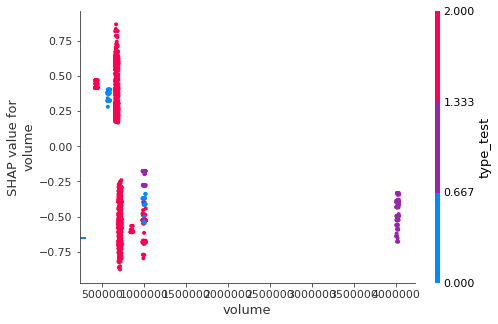

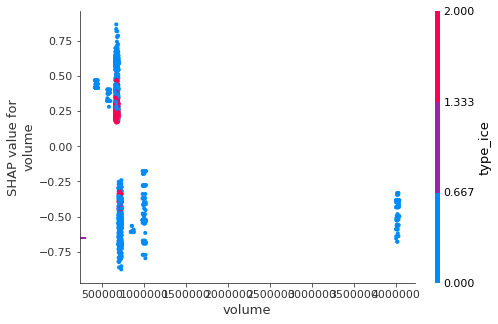

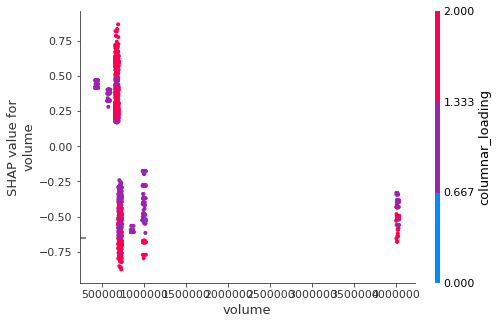

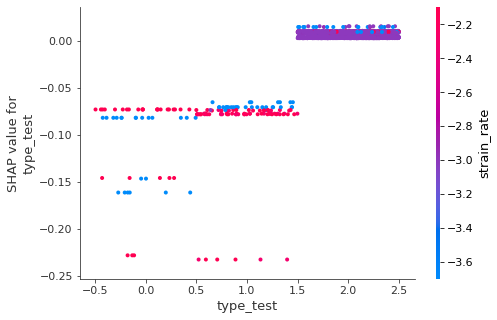

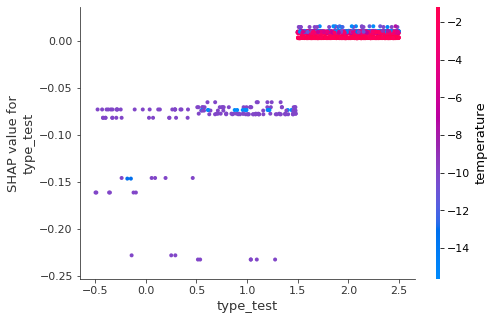

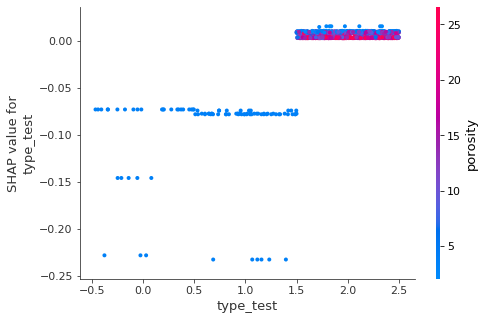

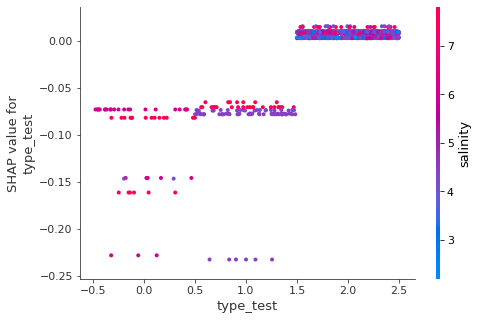

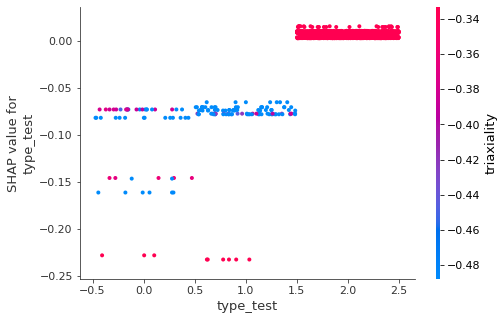

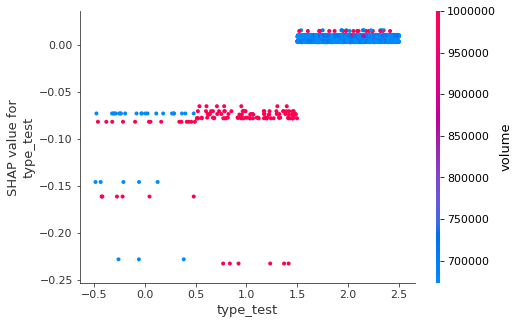

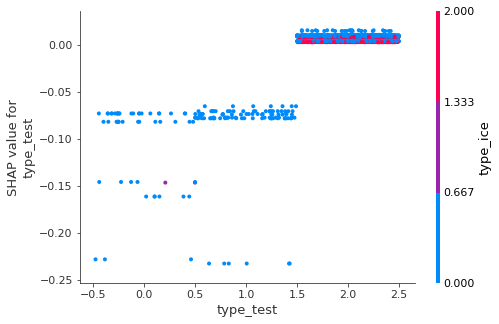

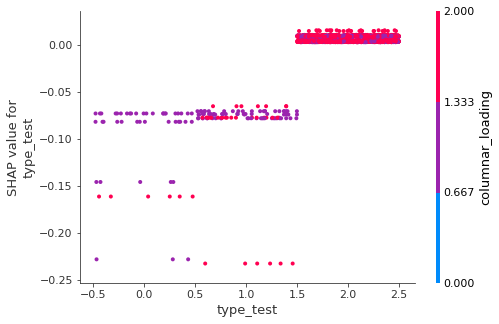

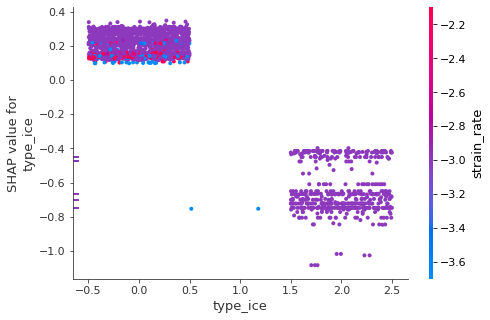

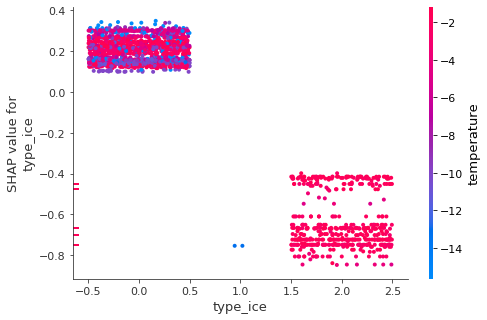

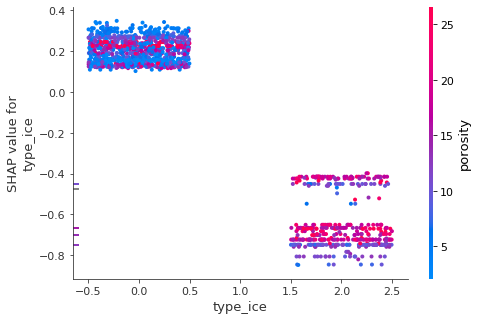

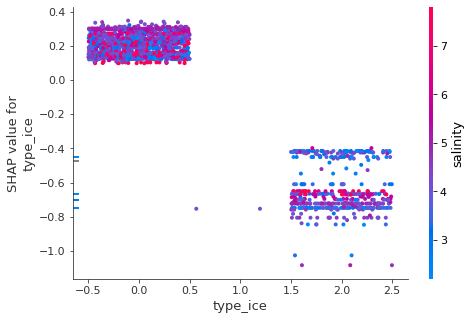

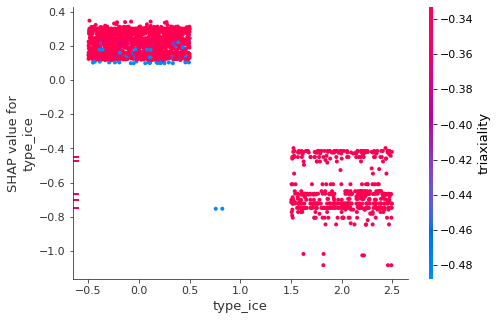

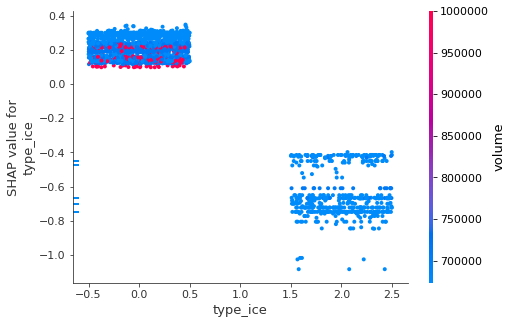

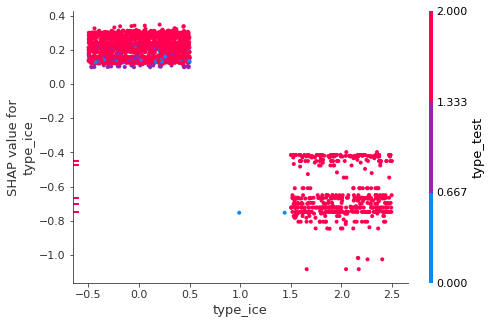

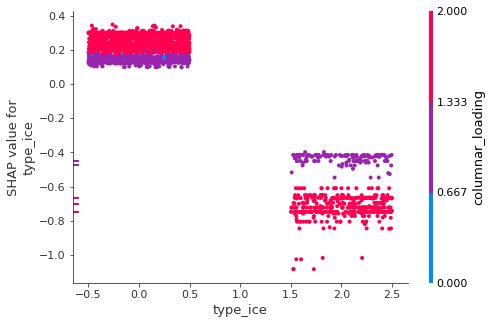

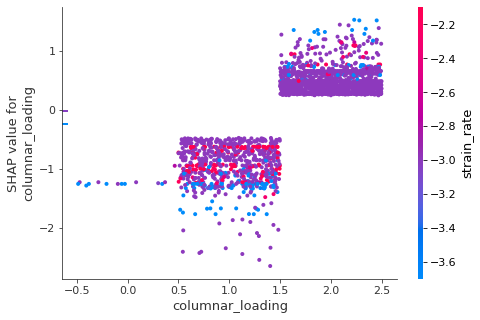

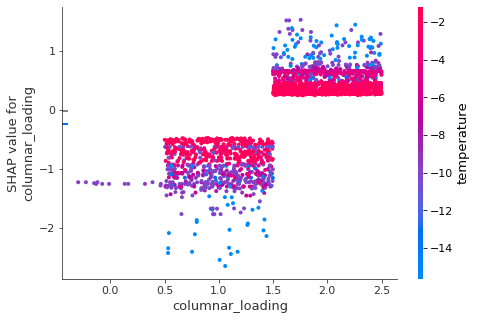

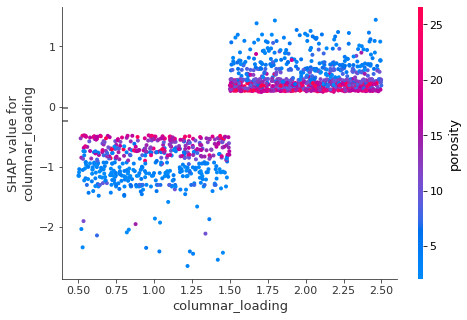

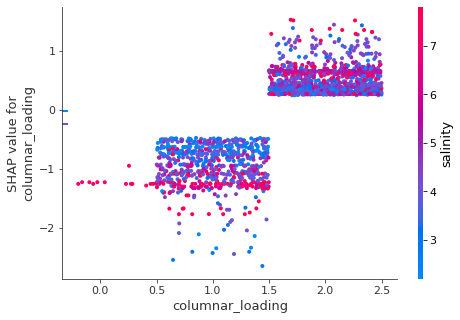

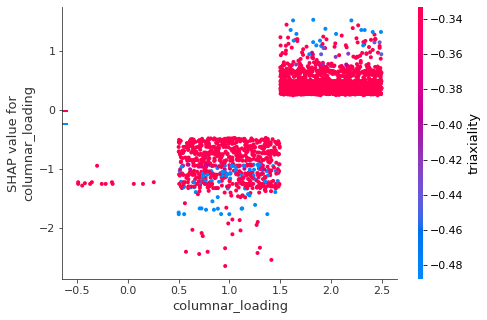

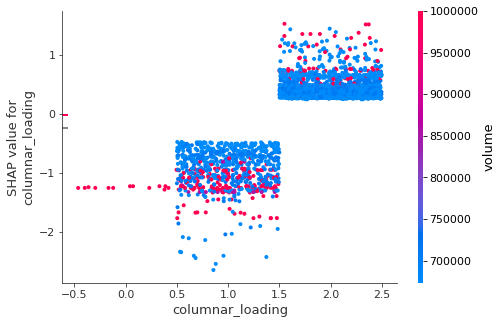

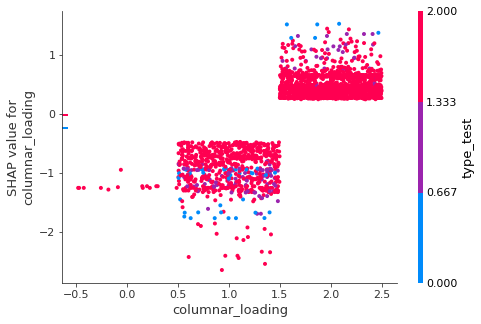

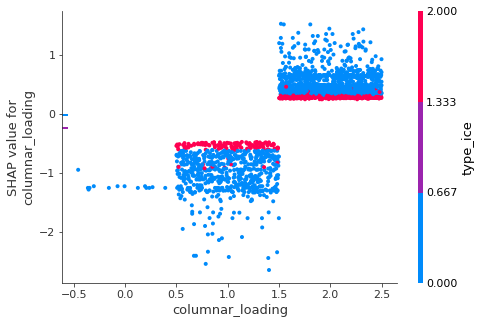

In [46]:
for feature in X.columns:
    for interaction_feature in X.columns:
        if interaction_feature != feature:
            shap.dependence_plot(feature, shap_values, X, interaction_index=interaction_feature, x_jitter=1)

## 4.4 Comparison to true strength values

(441,)
(441,)


<function matplotlib.pyplot.show(*args, **kw)>

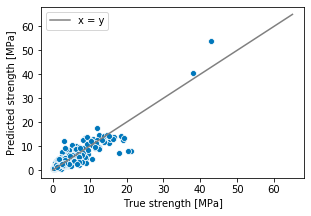

In [47]:
y_predict = pd.Series(y_predict)
print(y_predict.shape)
print(y_test.shape)
df_plot = pd.DataFrame()
df_plot['y_test'] = y_test.to_numpy()  # convert to numpy before writing to dataframe to get rid of indices
df_plot['y_predict'] = y_predict.to_numpy()
df_plot['error'] = np.abs(y_test.to_numpy() - y_predict.to_numpy())
df_plot.head()

#f = plt.figure()
fig, ax_ = plt.subplots()
sns.scatterplot(x='y_test', y='y_predict', color="#0077BB", data=df_plot)
linspace_ = np.linspace(0, 65)
plt.plot(linspace_, linspace_, color='grey', label='x = y')
ax_.set(ylabel='Predicted strength [MPa]', xlabel='True strength [MPa]')
plt.legend()
plt.gcf().set_size_inches(fig_size_) 

plt.savefig("rgsr_xgb_comparison_fw_ypredict_ytrue.pdf", format='pdf', dpi=dpi_)
plt.show